In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

### Convert excel to csv in a sorted timeline

In [2]:
# Define data directory path
DATA_DIR = Path("../../data/raw")

# Print paths of all Excel files
print("Excel file paths:")
for file in DATA_DIR.glob('*.xlsx'):
    print(file)

# Print paths of all CSV files
print("\nCSV file paths:")
for file in DATA_DIR.glob('*.csv'):
    print(file)

# Read the specific Excel files
df1 = pd.read_excel(DATA_DIR / "Ezpass Transactions Sept 15_21.xlsx")
df2 = pd.read_excel(DATA_DIR / "Ezpass Transactions Sept 8_14.xlsx")
df3 = pd.read_excel(DATA_DIR / "Ezpass Transactions Sept 1_7.xlsx")

# Combine the dataframes
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

# Reverse the order of rows in the combined dataframe
combined_df = combined_df.iloc[::-1].reset_index(drop=True)

# Convert to CSV format and save
combined_df.to_csv(DATA_DIR / "Ezpass_Transactions.csv", index=False)


Excel file paths:
../../data/raw/Ezpass Transactions Sept 1_7.xlsx
../../data/raw/Ezpass Transactions Sept 15_21.xlsx
../../data/raw/Ezpass Transactions Sept 8_14.xlsx

CSV file paths:
../../data/raw/Ezpass_Transactions.csv


In [3]:
DATA_DIR = Path("../../data/raw")
CSV_PATH = Path("../../data/raw/Ezpass_Transactions.csv")
INTERIM_DIR = Path("../../data/interim")
CLEANDF_PATH = Path("../../data/processed/ezpass_transactions.csv")

In [4]:
df = pd.read_csv(CSV_PATH)
display(df.head())
display(df.info())


,POSTING DATE,TRANSACTION DATE,TAG/PLATE NUMBER,AGENCY,DESCRIPTION,ENTRY TIME,ENTRY PLAZA,ENTRY LANE,EXIT TIME,EXIT PLAZA,EXIT LANE,VEHICLE TYPE CODE,AMOUNT,PREPAID,PLAN/RATE,FARE TYPE,BALANCE
0,2025-09-02,2025-09-02,96615555664,GSP,TOLL,NaN,-,-,08:08:10,GEG,04S,1,-2.17,Y,BUSINESS,N,4172.80
1,2025-09-02,2025-09-02,96615569666,GSP,TOLL,NaN,-,-,08:17:02,BLN,03N,1,-0.76,Y,BUSINESS,N,4172.04
2,2025-09-02,2025-09-02,96615548177,GSP,TOLL,NaN,-,-,06:14:27,BRN,04N,1,-0.76,Y,BUSINESS,N,4171.28
3,2025-09-02,2025-09-02,96615569665,GSP,TOLL,NaN,-,-,08:33:28,WRN,03N,1,-1.09,Y,BUSINESS,N,4170.19
4,2025-09-02,2025-09-02,96611594761,GSP,TOLL,NaN,-,-,08:35:54,WAN,01N,1,-1.09,Y,BUSINESS,N,4169.10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   POSTING DATE       2143 non-null   object 
 1   TRANSACTION DATE   2143 non-null   object 
 2   TAG/PLATE NUMBER   2143 non-null   object 
 3   AGENCY             2143 non-null   object 
 4   DESCRIPTION        2143 non-null   object 
 5   ENTRY TIME         467 non-null    object 
 6   ENTRY PLAZA        2143 non-null   object 
 7   ENTRY LANE         2143 non-null   object 
 8   EXIT TIME          2143 non-null   object 
 9   EXIT PLAZA         2143 non-null   object 
 10  EXIT LANE          2143 non-null   object 
 11  VEHICLE TYPE CODE  2143 non-null   object 
 12  AMOUNT             2143 non-null   float64
 13  PREPAID            2143 non-null   object 
 14  PLAN/RATE          2143 non-null   object 
 15  FARE TYPE          2143 non-null   object 
 16  BALANCE            2143 

None

### Format column names and dtype

Normalize column names

In [5]:
# Convert to snake_case: lowercase, spaces/slashes/dashes -> underscore
def to_snake(name: str) -> str:
    s = name.strip().lower()
    s = s.replace("/", " ").replace("-", " ").replace("\\", " ")
    s = re.sub(r"[^0-9a-zA-Z_ ]+", "", s)
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"_+", "_", s)
    return s

orig_cols = df.columns.tolist()
df.columns = [to_snake(c) for c in df.columns]

print("Original -> New column names:")
for o, n in zip(orig_cols, df.columns):
    print(f"- {o}  ->  {n}")

df.head(3)

Original -> New column names:
- POSTING DATE  ->  posting_date
- TRANSACTION DATE  ->  transaction_date
- TAG/PLATE NUMBER  ->  tag_plate_number
- AGENCY  ->  agency
- DESCRIPTION  ->  description
- ENTRY TIME  ->  entry_time
- ENTRY PLAZA  ->  entry_plaza
- ENTRY LANE  ->  entry_lane
- EXIT TIME  ->  exit_time
- EXIT PLAZA  ->  exit_plaza
- EXIT LANE  ->  exit_lane
- VEHICLE TYPE CODE  ->  vehicle_type_code
- AMOUNT  ->  amount
- PREPAID  ->  prepaid
- PLAN/RATE  ->  plan_rate
- FARE TYPE  ->  fare_type
- BALANCE  ->  balance


,posting_date,transaction_date,tag_plate_number,agency,description,entry_time,entry_plaza,entry_lane,exit_time,exit_plaza,exit_lane,vehicle_type_code,amount,prepaid,plan_rate,fare_type,balance
0,2025-09-02,2025-09-02,96615555664,GSP,TOLL,NaN,-,-,08:08:10,GEG,04S,1,-2.17,Y,BUSINESS,N,4172.80
1,2025-09-02,2025-09-02,96615569666,GSP,TOLL,NaN,-,-,08:17:02,BLN,03N,1,-0.76,Y,BUSINESS,N,4172.04
2,2025-09-02,2025-09-02,96615548177,GSP,TOLL,NaN,-,-,06:14:27,BRN,04N,1,-0.76,Y,BUSINESS,N,4171.28


Convert some columns to datetime format

In [6]:
# Ensure timestamp columns have datetime format
timestamp_cols = ["posting_date", "transaction_date", "entry_time", "exit_time"]
for c in timestamp_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

/var/folders/63/lvrmvc5j7pn6bxjxzcd1txt00000gn/T/ipykernel_44976/2364179571.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")
/var/folders/63/lvrmvc5j7pn6bxjxzcd1txt00000gn/T/ipykernel_44976/2364179571.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")


Turn Prepaid to Boooleans

In [7]:
# Since prepaid is 'Y'/'N' or 'TRUE'/'FALSE' etc., map to boolean
prepaid_map = {"Y": True, "N": False, "YES": True, "NO": False, "TRUE": True, "FALSE": False}
df["prepaid"] = (df["prepaid"].astype(str).str.upper().map(prepaid_map)).astype("boolean")

Check null and duplicates values

In [8]:
# Ensure numeric columns where expected
numeric_guess = []
for c in df.columns:
    if df[c].dtype == "object" and any(k in c for k in ["amount","distance","fee","cost","balance","speed"]):
        numeric_guess.append(c)

for c in numeric_guess:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop exact duplicates
before_dups = len(df)
df = df.drop_duplicates()
print(f"Dropped duplicates: {before_dups - len(df)}")

# Replace common "fake missing" placeholders with np.nan
df.replace(["-", "--", "N/A", "n/a", "na", ""], pd.NA, inplace=True)

# Quick NA summary
na = df.isna().mean().sort_values(ascending=False)
display(na.head(20))

Dropped duplicates: 0


entry_plaza          0.791414
entry_lane           0.791414
entry_time           0.782081
vehicle_type_code    0.045264
tag_plate_number     0.001867
fare_type            0.001867
plan_rate            0.001867
exit_plaza           0.001867
exit_lane            0.001867
posting_date         0.000000
amount               0.000000
prepaid              0.000000
exit_time            0.000000
transaction_date     0.000000
description          0.000000
agency               0.000000
balance              0.000000
dtype: float64

In [9]:
# Drop columns with 80% missing values
df = df.drop(columns=["entry_time", "entry_lane", "entry_plaza"])

### EDA Quick Look

In [10]:
print("Rows, Cols:", df.shape)
print("\nDtypes:")
print(df.dtypes)

print("\nTop rows:")
display(df.head(5))

print("\nNull Values (% by column):")
miss = (df.isna().mean()*100).round(1).sort_values(ascending=False)
display(miss.head(20))

Rows, Cols: (2143, 14)

Dtypes:
posting_date         datetime64[ns]
transaction_date     datetime64[ns]
tag_plate_number             object
agency                       object
description                  object
exit_time            datetime64[ns]
exit_plaza                   object
exit_lane                    object
vehicle_type_code            object
amount                      float64
prepaid                     boolean
plan_rate                    object
fare_type                    object
balance                     float64
dtype: object

Top rows:


,posting_date,transaction_date,tag_plate_number,agency,description,exit_time,exit_plaza,exit_lane,vehicle_type_code,amount,prepaid,plan_rate,fare_type,balance
0,2025-09-02,2025-09-02,96615555664,GSP,TOLL,2025-10-07 08:08:10,GEG,04S,1,-2.17,True,BUSINESS,N,4172.80
1,2025-09-02,2025-09-02,96615569666,GSP,TOLL,2025-10-07 08:17:02,BLN,03N,1,-0.76,True,BUSINESS,N,4172.04
2,2025-09-02,2025-09-02,96615548177,GSP,TOLL,2025-10-07 06:14:27,BRN,04N,1,-0.76,True,BUSINESS,N,4171.28
3,2025-09-02,2025-09-02,96615569665,GSP,TOLL,2025-10-07 08:33:28,WRN,03N,1,-1.09,True,BUSINESS,N,4170.19
4,2025-09-02,2025-09-02,96611594761,GSP,TOLL,2025-10-07 08:35:54,WAN,01N,1,-1.09,True,BUSINESS,N,4169.10



Null Values (% by column):


vehicle_type_code    4.5
tag_plate_number     0.2
exit_plaza           0.2
exit_lane            0.2
plan_rate            0.2
fare_type            0.2
posting_date         0.0
transaction_date     0.0
agency               0.0
description          0.0
exit_time            0.0
amount               0.0
prepaid              0.0
balance              0.0
dtype: float64

## Distribution of key numeric columns

In [11]:
def plot_distribution(data, column, bins=30, figsize=(5,5), title=None, 
                     xlabel=None, ylabel="Frequency", color='skyblue'):
                     
    plt.figure(figsize=figsize)
    
    # Create histogram
    plt.hist(data[column], bins=bins, color=color, edgecolor='black')
    
    # Set title and labels
    title = title if title else f"Distribution of {column}"
    xlabel = xlabel if xlabel else column
    plt.title(title, pad=15, fontsize=12)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Calculate and plot mean and median
    mean_val = data[column].mean()
    median_val = data[column].median()
    
    plt.axvline(mean_val, color='red', linestyle='--', alpha=0.8,
                label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='green', linestyle='--', alpha=0.8,
                label=f'Median: {median_val:.1f}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

### Distribution for 'amount'

In [12]:
display(df['amount'].describe(percentiles=[.5,.9,.95,.99,.999]))
display(df['amount'].nlargest(10))      # biggest values
display(df['amount'].nsmallest(10))     # negative/refunds?

count     2143.000000
mean         2.463943
std        224.503854
min        -17.240000
50%         -2.170000
90%         -0.760000
95%         -0.760000
99%         -0.760000
99.9%        1.441440
max      10390.000000
Name: amount, dtype: float64

928     10390.00
2081        2.26
318         1.68
110         0.00
1201        0.00
1202        0.00
1505        0.00
1509        0.00
2055        0.00
1          -0.76
Name: amount, dtype: float64

1049   -17.24
2043   -16.06
975    -14.88
181    -14.65
976    -14.65
1414   -14.65
1557   -14.65
1727   -14.65
1852   -14.65
755    -14.06
Name: amount, dtype: float64

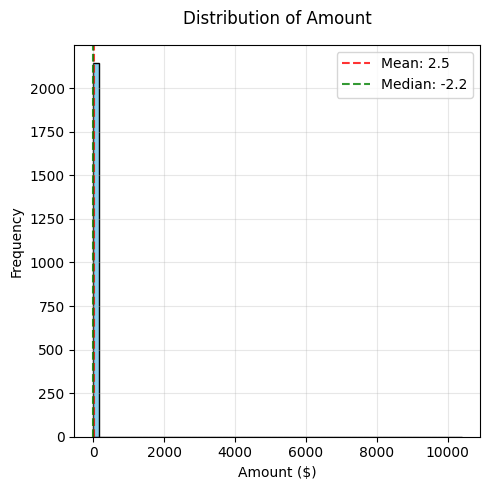

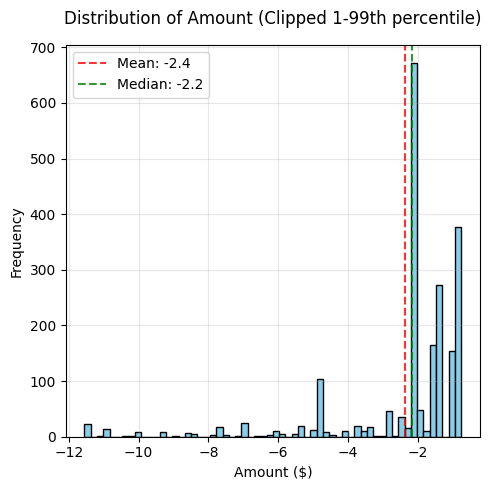

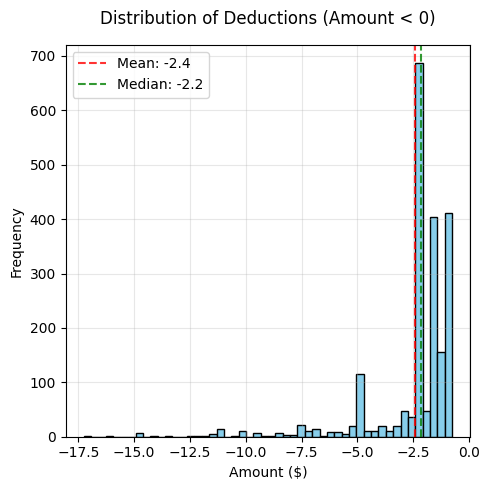

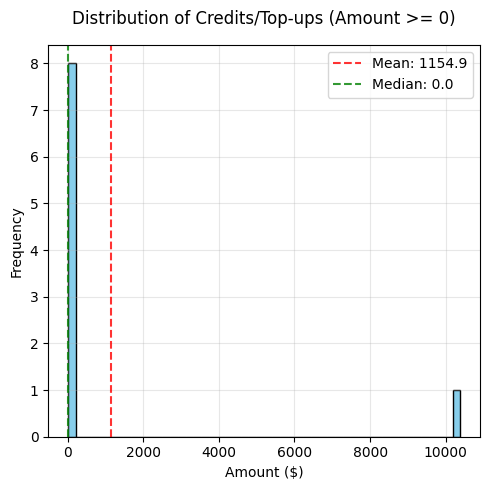

In [13]:
# Plot distribution for amount
plot_distribution(df, 'amount', bins=60, figsize=(5,5), 
                 title='Distribution of Amount',
                 xlabel='Amount ($)', ylabel='Frequency')

# Plot distribution for amount, clipped at 99th percentile
q01, q99 = df['amount'].quantile([0.01, 0.99])
df_clipped = df.copy()
df_clipped['amount'] = df['amount'].clip(lower=q01, upper=q99)

plot_distribution(df_clipped, 'amount', bins=60, figsize=(5,5),
                 title='Distribution of Amount (Clipped 1-99th percentile)', 
                 xlabel='Amount ($)', ylabel='Frequency')

# Plot separate distributions for negative and positive amounts
df_neg = df[df['amount'] < 0]
df_pos = df[df['amount'] >= 0]

plot_distribution(df_neg, 'amount', bins=50, figsize=(5,5),
                 title='Distribution of Deductions (Amount < 0)',
                 xlabel='Amount ($)', ylabel='Frequency')

plot_distribution(df_pos, 'amount', bins=50, figsize=(5,5), 
                 title='Distribution of Credits/Top-ups (Amount >= 0)',
                 xlabel='Amount ($)', ylabel='Frequency')

### Distribution for balance

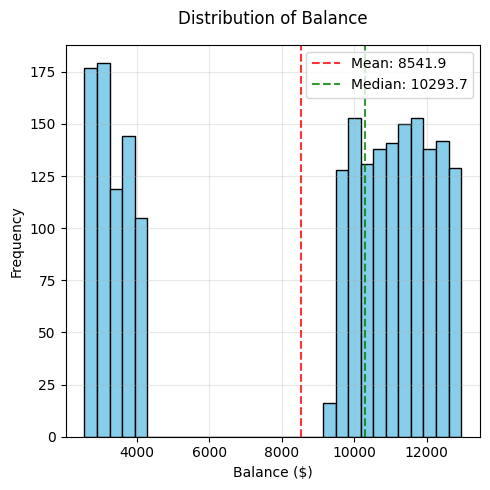

In [14]:
# Plot distribution for balance
plot_distribution(df, 'balance', bins=30, figsize=(5,5),
                 title='Distribution of Balance',
                 xlabel='Balance ($)', ylabel='Frequency')

### Distribution for exit_time, transaction_time, posting_day, posting_lag_day

In [15]:
df['exit_time'].head()

0   2025-10-07 08:08:10
1   2025-10-07 08:17:02
2   2025-10-07 06:14:27
3   2025-10-07 08:33:28
4   2025-10-07 08:35:54
Name: exit_time, dtype: datetime64[ns]

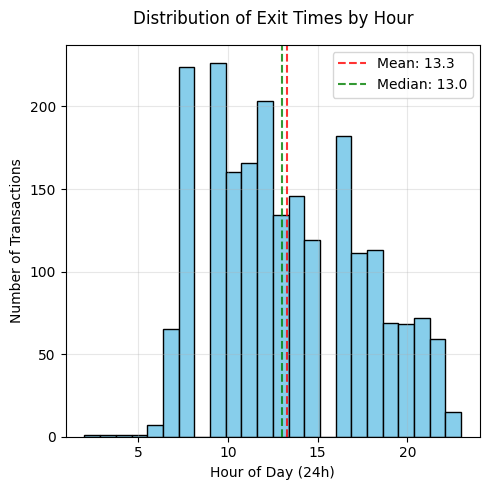

In [16]:
# Convert exit_time to hour of day for plotting
df['exit_hour'] = pd.to_datetime(df['exit_time']).dt.hour

# Plot distribution of exit hours
plot_distribution(df, 'exit_hour', bins=24, figsize=(5,5),
                 title='Distribution of Exit Times by Hour',
                 xlabel='Hour of Day (24h)', ylabel='Number of Transactions')


Mean transaction date: 2025-09-10 15:58:12.487167488
Median transaction date: 2025-09-10 00:00:00


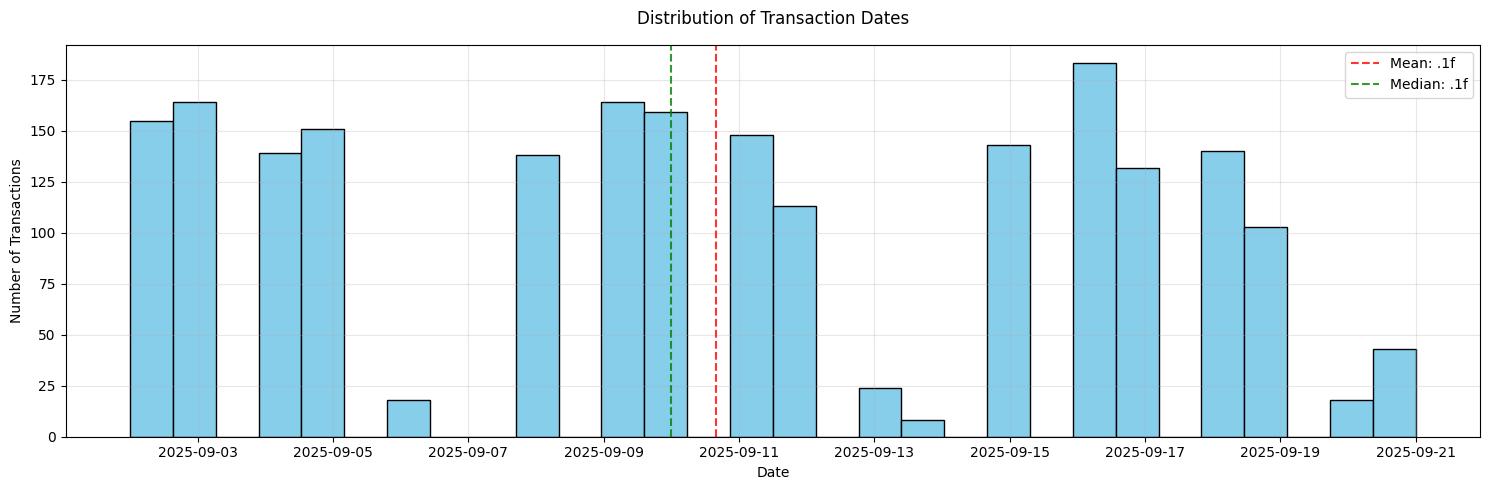

In [17]:
# Plot distribution of transaction dates
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Calculate mean and median transaction dates
mean_date = df['transaction_date'].mean()
median_date = df['transaction_date'].median()

print(f"Mean transaction date: {mean_date}")
print(f"Median transaction date: {median_date}")

plot_distribution(df, 'transaction_date', bins=30, figsize=(15,5),
                 title='Distribution of Transaction Dates',
                 xlabel='Date', ylabel='Number of Transactions')


Mean posting date: 2025-09-11 01:23:19.346710528
Median posting date: 2025-09-11 00:00:00


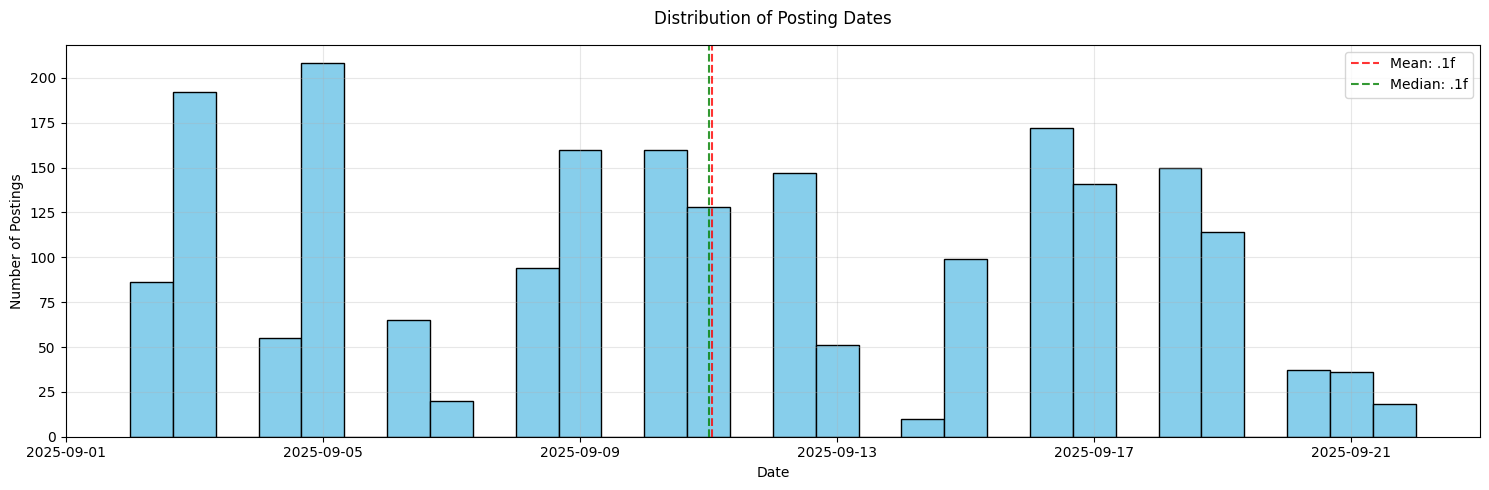

In [18]:
# Plot distribution of posting dates
df['posting_date'] = pd.to_datetime(df['posting_date'])

# Calculate mean and median dates
mean_date = df['posting_date'].mean()
median_date = df['posting_date'].median()

print(f"Mean posting date: {mean_date}")
print(f"Median posting date: {median_date}")

plot_distribution(df, 'posting_date', bins=30, figsize=(15,5),
                 title='Distribution of Posting Dates',
                 xlabel='Date', ylabel='Number of Postings',
                 color='skyblue')


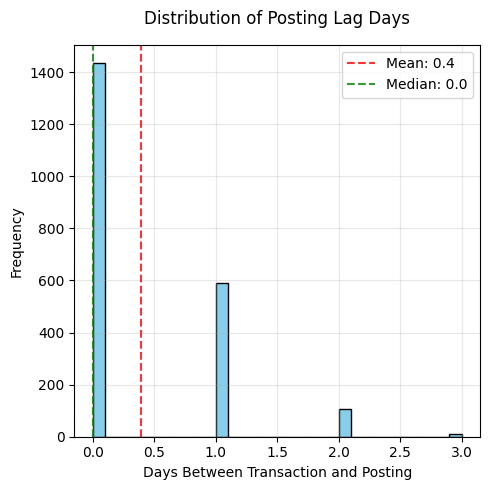

In [19]:
df["post_lag_days"] = (pd.to_datetime(df["posting_date"]) 
                       - pd.to_datetime(df["transaction_date"])).dt.days

plot_distribution(df, 'post_lag_days',
                 bins=30,
                 figsize=(5,5),
                 title='Distribution of Posting Lag Days',
                 xlabel='Days Between Transaction and Posting',
                 color='skyblue')


## Categorical EDA

### Overview

In [20]:
# Get categorical columns that have 50 or fewer unique values
categorical_columns = []
for column in df.columns:
    if df[column].dtype == "object":
        n_unique = df[column].nunique()
        print(f"{column}: {n_unique} unique values") # Debug print
        if n_unique <= 50:
            categorical_columns.append(column)
cat_cols = categorical_columns
print("\nCandidate categorical columns:", cat_cols[:10])

# Show top categories for a few columns
for c in cat_cols[:5]:
    print(f"\n{c}:")
    display(df[c].value_counts().head(10).to_frame(name="count"))

tag_plate_number: 345 unique values
agency: 11 unique values
description: 4 unique values
exit_plaza: 105 unique values
exit_lane: 91 unique values
vehicle_type_code: 3 unique values
plan_rate: 2 unique values
fare_type: 2 unique values

Candidate categorical columns: ['agency', 'description', 'vehicle_type_code', 'plan_rate', 'fare_type']

agency:


,count
agency,
GSP,1173
NJTP,459
SJ,394
PTC,87
DRJTBC,14
DRPA,5
NJ E-ZPass,4
PANYNJ,3
CBDTP,2



description:


,count
description,
TOLL,2139
Paterson Plank Adj,2
Service Fee,1
Prepaid Payment,1



vehicle_type_code:


,count
vehicle_type_code,
1,1646
2,399
3,1



plan_rate:


,count
plan_rate,
BUSINESS,2135
TWORAMP,4



fare_type:


,count
fare_type,
N,2134
M,5


### Agency class description

In [21]:
AGENCY_MAP = {
    "GSP":"Garden State Parkway",
    "NJTP":"New Jersey Turnpike",
    "SJ":"South Jersey Transportation Authority",
    "PTC":"Pennsylvania Turnpike Commission",
    "DRJTBC":"Delaware River Joint Toll Bridge Commission",
    "DRPA":"Delaware River Port Authority",
    "PANYNJ":"Port Authority of NY & NJ",
    "BCBC":"Burlington County Bridge Commission",
    "NJ E-ZPass":"NJ E-ZPass (back office)",
    "CBDTP":"(verify) — possible CBBT"
}

agency_df = pd.DataFrame(list(AGENCY_MAP.items()), columns=['agency', 'description'])
display(agency_df)

,agency,description
0,GSP,Garden State Parkway
1,NJTP,New Jersey Turnpike
2,SJ,South Jersey Transportation Authority
3,PTC,Pennsylvania Turnpike Commission
4,DRJTBC,Delaware River Joint Toll Bridge Commission
5,DRPA,Delaware River Port Authority
6,PANYNJ,Port Authority of NY & NJ
7,BCBC,Burlington County Bridge Commission
8,NJ E-ZPass,NJ E-ZPass (back office)
9,CBDTP,(verify) — possible CBBT


In [22]:
# Map normalized agency codes to full names 
df['agency_fullname'] = df['agency'].map(AGENCY_MAP)

In [23]:
# Check for any agencies that didn't get mapped to full names
unmapped_agencies = df[df['agency_fullname'].isna()][['agency', 'agency_fullname']]
print("\nUnmapped agencies:")
display(unmapped_agencies.drop_duplicates())



Unmapped agencies:


,agency,agency_fullname
2035,MTAB&T,NaN


### Tag / Plate Number and Vehicle Type

Policy flags: `flag_vehicle_class_disallowed` → `vehicle_type >= 3` (Judiciary owns only cars/vans; class ≥3 never allowed).

In [24]:
df['tag_plate_number'].nunique()

# Top repeats
df['tag_plate_number'].value_counts().head(50)

tag_plate_number
96699155565    38
96684774777    31
96643569649    29
96643569694    29
96687569667    29
96643569644    28
96688695669    28
96644559387    26
96699448864    26
96643569659    24
96644695669    24
96699148861    24
96699848868    23
96684559787    23
96611695669    23
96643569579    22
96687569689    21
96615569695    21
96687569686    21
96643555666    21
96615555666    21
96699433365    20
96684559796    19
96687569579    19
96643569663    18
96615569659    18
96614559587    18
96699449534    17
96687569568    17
96615569665    16
96643569576    16
96687569659    16
96643569557    16
96687569666    16
96615569576    16
96643599336    15
96643569695    15
96615569579    15
96684559788    15
96699464474    14
96699736594    14
96687555666    14
96699756591    13
96687569557    13
96684774776    13
96644774337    13
96615569557    12
96615569666    12
96699877775    12
96699155575    12
Name: count, dtype: int64

Vehical Class Description Source: https://www.njta.com/toll-calculator

In [25]:
VEH_CLASS_MAP = {
    "1": "Car",
    "2": "Truck", 
    "3": "Heavy"
}

veh_class_df = pd.DataFrame(list(VEH_CLASS_MAP.items()), columns=['vehicle_type', 'vehicle_class'])
display(veh_class_df)

# Map vehicle type codes to vehicle classes
df['vehicle_class'] = df['vehicle_type_code'].astype(str).map(VEH_CLASS_MAP)

,vehicle_type,vehicle_class
0,1,Car
1,2,Truck
2,3,Heavy


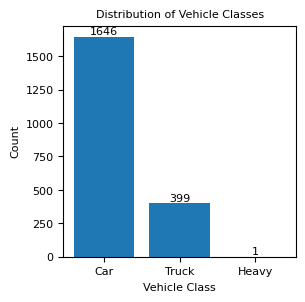

In [26]:
# Count and plot vehicle classes
vehicle_class_counts = df['vehicle_class'].value_counts()

plt.figure(figsize=(3,3))
plt.bar(vehicle_class_counts.index, vehicle_class_counts.values, tick_label=vehicle_class_counts.index)
plt.title('Distribution of Vehicle Classes', fontsize=8)
plt.xlabel('Vehicle Class', fontsize=8) 
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Add count labels on top of bars
for i, v in enumerate(vehicle_class_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)

plt.show()

### Exit Plaza

In [27]:
print("Unique exit plazas:", df['exit_plaza'].nunique())

Unique exit plazas: 105


NJ Plaza Abbrev Source: https://www.ezpassnj.com/en/about/plazas.shtml

In [28]:
# PLAZA MASTER MAP: code -> (description, agency)
PLAZA_MAP = {
    # GSP (Garden State Parkway)
    "PVK": ("Pascack Valley", "GSP"),
    "PRS": ("Paramus South", "GSP"),
    "PRN": ("Paramus North", "GSP"),
    "BER": ("Bergen", "GSP"),
    "SAB": ("Saddle Brook", "GSP"),
    "CLS": ("Clifton South", "GSP"),
    "CLN": ("Clifton North", "GSP"),
    "PSS": ("Passaic South", "GSP"),
    "PSN": ("Passaic North", "GSP"),
    "WAS": ("Watchung South", "GSP"),
    "WAN": ("Watchung North", "GSP"),
    "ESS": ("Essex", "GSP"),
    "BLS": ("Bloomfield South", "GSP"),
    "BLN": ("Bloomfield North", "GSP"),
    "EOR": ("East Orange", "GSP"),
    "IRS": ("Irvington South", "GSP"),
    "IRN": ("Irvington North", "GSP"),
    "UNR": ("Union Ramp", "GSP"),
    "UNI": ("Union", "GSP"),
    "RAS": ("Raritan South", "GSP"),
    "MAT": ("Matawan", "GSP"),
    "KEY": ("Keyport", "GSP"),
    "HOS": ("Holmdel South", "GSP"),
    "HON": ("Holmdel North", "GSP"),
    "RBS": ("Red Bank South", "GSP"),
    "RBN": ("Red Bank North", "GSP"),
    "EAT": ("Eatontown", "GSP"),
    "ASP": ("Asbury Park", "GSP"),
    "BES": ("Belmar South", "GSP"),
    "BEN": ("Belmar North", "GSP"),
    "BRS": ("Brick South", "GSP"),
    "BRN": ("Brick North", "GSP"),
    "LWS": ("Lakewood South", "GSP"),
    "LWN": ("Lakewood North", "GSP"),
    "TRV": ("Toms River", "GSP"),
    "LRS": ("Lacey Rd South", "GSP"),
    "LRN": ("Lacey Rd North", "GSP"),
    "BAR": ("Barnegat", "GSP"),
    "BKS": ("Berkeley Ramp South", "GSP"),
    "BKN": ("Berkeley Ramp North", "GSP"),
    "NGR": ("New Gretna", "GSP"),
    "WRS": ("Waretown South", "GSP"),
    "WRN": ("Waretown North", "GSP"),
    "SPT": ("Somers Point", "GSP"),
    "GEG": ("Great Egg", "GSP"),
    "CMY": ("Cape May", "GSP"),
    "WWS": ("Wildwood South", "GSP"),
    "WWN": ("Wildwood North", "GSP"),
    "SAY": ("Sayreville", "GSP"),

    # NJTP (New Jersey Turnpike) — keep numeric codes as strings
    "1":   ("Delaware Memorial Bridge", "NJTP"),
    "2":   ("Swedesboro/Chester", "NJTP"),
    "3":   ("Woodbury/S. Camden/NJ Aquarium", "NJTP"),
    "4":   ("Camden/Philadelphia/NJ Aquarium", "NJTP"),
    "5":   ("Burlington/Mt. Holly", "NJTP"),
    "6":   ("PA Turnpike/Florence", "NJTP"),
    "6A":  ("PA Turnpike/Florence", "NJTP"),
    "6B":  ("Rte. 130 Credit Ramp", "NJTP"),
    "7":   ("Bordentown/Trenton", "NJTP"),
    "7A":  ("I-195/Trenton/Shore Points", "NJTP"),
    "8":   ("Hightstown/Freehold", "NJTP"),
    "8A":  ("Jamesburg/Cranbury", "NJTP"),
    "9":   ("New Brunswick/Admin Bldg", "NJTP"),
    "10":  ("I-287/Metuchen/Edison Twsp", "NJTP"),
    "11":  ("GSP/Woodbridge/The Amboys", "NJTP"),
    "12":  ("Carteret/Rahway", "NJTP"),
    "13":  ("I-278/Eliz/Goethals/Verrazano", "NJTP"),
    "13A": ("Newark Aprt/Elizabeth Seaport", "NJTP"),
    "14":  ("I-78/Newark Airport", "NJTP"),
    "14A": ("Bayonne", "NJTP"),
    "14B": ("Jersey City/Liberty State Park", "NJTP"),
    "14C": ("Holland Tunnel", "NJTP"),
    "15E": ("Newark/Jersey City", "NJTP"),
    "15W": ("I-280/Newark/The Oranges", "NJTP"),
    "15X": ("Secaucus Transfer Station", "NJTP"),
    "16E": ("Lincoln Tunnel/NJ 3/Secaucus", "NJTP"),
    "16W": ("Sprtsplx/NJ 3/Secaucus/Ruthrfrd", "NJTP"),
    "17":  ("Secaucus/US 46", "NJTP"),
    "18E": ("Lincoln Tunnel/NJ 3/Secaucus", "NJTP"),
    "18W": ("Geo Washington Br/US 46/I-80", "NJTP"),
    "19W": ("Carlstadt", "NJTP"),

    # SJ (South Jersey Transportation Authority / AC Expressway + local bridges)
    "APL": ("Pleasantville Mainline Barrier", "SJ"),
    "AR9": ("Route 9", "SJ"),
    "APO": ("Pomona", "SJ"),
    "ACY": ("AC Airport", "SJ"),
    "AML": ("Mays Landing", "SJ"),
    "A50": ("Route 50", "SJ"),
    "AEH": ("Egg Harbor Mainline Barrier", "SJ"),
    "AH":  ("Hammonton Ramp", "SJ"),
    "AWN": ("Winslow Ramp", "SJ"),
    "AWL": ("Williamstown Ramp", "SJ"),
    "ACK": ("Cross Keys", "SJ"),
    "OCL": ("Ocean City-Longport Bridge", "SJ"),
    "CIB": ("Corsons Inlet Bridge", "SJ"),
    "TIB": ("Townsend's Inlet Bridge", "SJ"),
    "GSB": ("Grassy Sound Bridge", "SJ"),
    "MTB": ("Middle Thorofare Bridge", "SJ"),

    # DRPA (Delaware River Port Authority)
    "BRB": ("Betsy Ross Br", "DRPA"),
    "BFB": ("Ben Franklin Br", "DRPA"),
    "WWB": ("Walt Whitman Br", "DRPA"),
    "CBB": ("Commodore Barry Br", "DRPA"),

    # DRBA (Delaware River & Bay Authority)
    "DMB": ("Delaware Memorial Br", "DRBA"),

    # BCBC (Burlington County Bridge Commission)
    "TPB": ("Tacony Palmyra Br", "BCBC"),
    "BBB": ("Burlington Bristol Br", "BCBC"),

    # DRJTBC (Delaware River Joint Toll Bridge Commission)
    "T-M": ("Trenton-Morrisville Br", "DRJTBC"),
    "NHL": ("New Hope-Lambertville Br", "DRJTBC"),
    "I78": ("I-78 Br", "DRJTBC"),
    "E-P": ("Easton-Phillipsburg Br", "DRJTBC"),
    "P-C": ("Portland-Columbia Br", "DRJTBC"),
    "DWG": ("Delaware Water Gap Br", "DRJTBC"),
    "M-M": ("Milford-Montague Br", "DRJTBC"),
    "O78": ("Interstate 78-ORT", "DRJTBC"),
    "ODW": ("Delaware Water Gap-ORT", "DRJTBC"),
    "OSF": ("Scudder Falls Br", "DRJTBC"),
}
# Create DataFrame from PLAZA_MAP dictionary
plaza_df = pd.DataFrame([
    {
        'plaza_code': code,
        'plaza_desc': desc,
        'agency': agency
    }
    for code, (desc, agency) in PLAZA_MAP.items()
])

# Display first few rows
display(plaza_df.head())


,plaza_code,plaza_desc,agency
0,PVK,Pascack Valley,GSP
1,PRS,Paramus South,GSP
2,PRN,Paramus North,GSP
3,BER,Bergen,GSP
4,SAB,Saddle Brook,GSP


In [29]:
def norm(code) -> str:
    if pd.isna(code): return ""
    s = str(code).upper()
    s = s.replace("\u00A0", " ")       # non-breaking space → space
    s = s.strip()
    s = re.sub(r"\s+", "", s)          # remove all internal spaces: "7 A" -> "7A"
    s = re.sub(r"[^A-Z0-9\-]", "", s)  # keep only A-Z, 0-9, hyphen (for T-M, E-P, etc.)
    return s

# Build a normalized mapping dict
PLAZA_MAP_NORM = { norm(k): v for k, v in PLAZA_MAP.items() }

# Apply normalization
df["exit_plaza"] = df["exit_plaza"].map(norm)

# Map to fullname and agency, using unidentified/original agency as fallback
df["exit_plaza_fullname"] = df["exit_plaza"].map(lambda k: PLAZA_MAP_NORM.get(k, ("unidentified", None))[0])
df["exit_plaza_agency"] = df.apply(
    lambda row: PLAZA_MAP_NORM.get(row["exit_plaza"], (None, row["agency"]))[1], 
    axis=1
)

# See what's still unmapped but now marked as unidentified
unmapped = df.loc[df["exit_plaza_fullname"] == "unidentified", "exit_plaza"].value_counts()
print("Unidentified plazas:\n", unmapped.head(20))

Unidentified plazas:
 exit_plaza
341    22
349    22
336    18
331    16
H43     6
        4
353     3
SF      3
PPR     2
CRZ     2
BB      1
RKM     1
LT      1
GWL     1
Name: count, dtype: int64


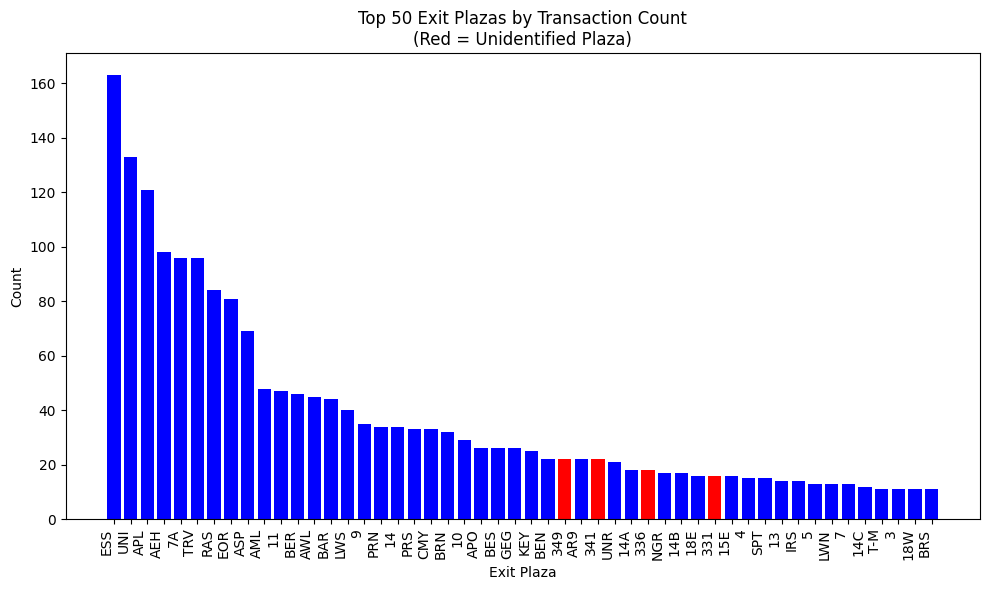

In [30]:
plt.figure(figsize=(10, 6))

# Get top 50 exit plazas
top_50 = df['exit_plaza'].value_counts().head(50)

# Create colors array - red for unidentified, blue for others
colors = ['red' if df[df['exit_plaza'] == plaza]['exit_plaza_fullname'].iloc[0] == 'unidentified' 
          else 'blue' for plaza in top_50.index]

plt.bar(top_50.index, top_50.values, color=colors)
plt.xticks(rotation=90, ha='right')
plt.xlabel('Exit Plaza')
plt.ylabel('Count')
plt.title('Top 50 Exit Plazas by Transaction Count\n(Red = Unidentified Plaza)')
plt.tight_layout()
plt.show()

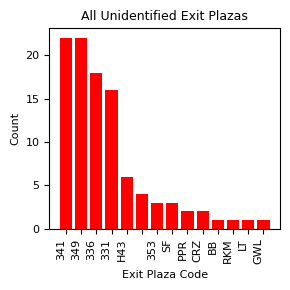

In [31]:
# Get only unidentified plazas
unidentified = df[df['exit_plaza_fullname'] == 'unidentified']['exit_plaza'].value_counts()

plt.figure(figsize=(3,3))
plt.bar(unidentified.index, unidentified.values, color='red')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.xlabel('Exit Plaza Code', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.title('All Unidentified Exit Plazas', fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

### Fare Type

In [32]:
# Convert fare_type to string
df["fare_type"] = df["fare_type"].astype("string")

# Check unique fare types and their counts
print("Fare type value counts:")
print(df["fare_type"].value_counts())

# Check for null values
print("\nNull values in fare_type:")
print(df["fare_type"].isnull().sum())


Fare type value counts:
fare_type
N    2134
M       5
Name: count, dtype: Int64

Null values in fare_type:
4


Enfornce dtype for clean schema

In [33]:
print("Before conversion:")
df.info()

Before conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   posting_date         2143 non-null   datetime64[ns]
 1   transaction_date     2143 non-null   datetime64[ns]
 2   tag_plate_number     2139 non-null   object        
 3   agency               2143 non-null   object        
 4   description          2143 non-null   object        
 5   exit_time            2143 non-null   datetime64[ns]
 6   exit_plaza           2143 non-null   object        
 7   exit_lane            2139 non-null   object        
 8   vehicle_type_code    2046 non-null   object        
 9   amount               2143 non-null   float64       
 10  prepaid              2143 non-null   boolean       
 11  plan_rate            2139 non-null   object        
 12  fare_type            2139 non-null   string        
 13  balance       

In [34]:
# Convert strings to string dtype
string_cols = [
    "tag_plate_number","vehicle_type_code","vehicle_class","agency","agency_fullname",
    "description","exit_plaza","exit_plaza_fullname","exit_plaza_agency","exit_lane",
    "plan_rate"
]
for c in string_cols:
    if c in df.columns:
        df[c] = df[c].astype("string")

print("After conversion:")        
df.info()

After conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   posting_date         2143 non-null   datetime64[ns]
 1   transaction_date     2143 non-null   datetime64[ns]
 2   tag_plate_number     2139 non-null   string        
 3   agency               2143 non-null   string        
 4   description          2143 non-null   string        
 5   exit_time            2143 non-null   datetime64[ns]
 6   exit_plaza           2143 non-null   string        
 7   exit_lane            2139 non-null   string        
 8   vehicle_type_code    2046 non-null   string        
 9   amount               2143 non-null   float64       
 10  prepaid              2143 non-null   boolean       
 11  plan_rate            2139 non-null   string        
 12  fare_type            2139 non-null   string        
 13  balance        

In [35]:
# Quick sanity checks
print(df["exit_hour"].between(0, 23).all())

True


## Correlation heatmap (numerical values only)

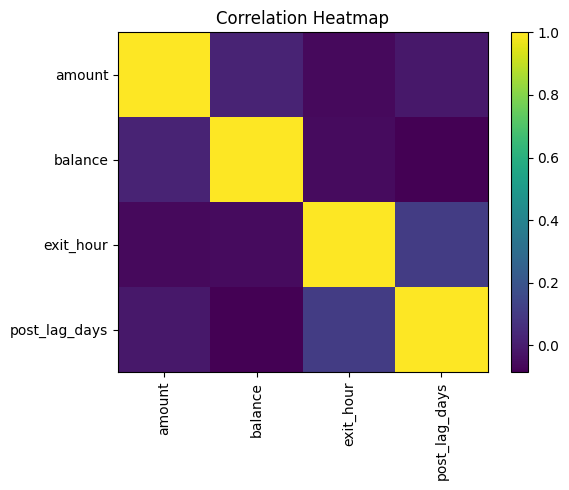

In [36]:
num_df = df.select_dtypes(include=[np.number]).dropna(axis=1, how="all")
if num_df.shape[1] >= 2:
    corr = num_df.corr(numeric_only=True)
    plt.figure(figsize=(6, 5))
    plt.imshow(corr, aspect='auto', interpolation='nearest')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation Heatmap")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for a correlation heatmap.")

## Final DataFrame Check

In [37]:
# Group columns logically
cols = [
    # Transaction metadata
    'posting_date',
    'transaction_date', 
    'post_lag_days',
    
    # Vehicle info
    'tag_plate_number',
    'vehicle_type_code',
    'vehicle_class',
    
    # Agency info
    'agency',
    'agency_fullname',
    'description',
    
    # Exit details
    'exit_time',
    'exit_hour',
    'exit_plaza',
    'exit_plaza_fullname',
    'exit_plaza_agency',
    'exit_lane',
    
    # Payment details
    'amount',
    'balance',
    'prepaid',
    'plan_rate',
    'fare_type'
]

df = df[cols]
df.columns

Index(['posting_date', 'transaction_date', 'post_lag_days', 'tag_plate_number',
       'vehicle_type_code', 'vehicle_class', 'agency', 'agency_fullname',
       'description', 'exit_time', 'exit_hour', 'exit_plaza',
       'exit_plaza_fullname', 'exit_plaza_agency', 'exit_lane', 'amount',
       'balance', 'prepaid', 'plan_rate', 'fare_type'],
      dtype='object')

In [38]:
df.head()

,posting_date,transaction_date,post_lag_days,tag_plate_number,vehicle_type_code,vehicle_class,agency,agency_fullname,description,exit_time,exit_hour,exit_plaza,exit_plaza_fullname,exit_plaza_agency,exit_lane,amount,balance,prepaid,plan_rate,fare_type
0,2025-09-02,2025-09-02,0,96615555664,1,Car,GSP,Garden State Parkway,TOLL,2025-10-07 08:08:10,8,GEG,Great Egg,GSP,04S,-2.17,4172.80,True,BUSINESS,N
1,2025-09-02,2025-09-02,0,96615569666,1,Car,GSP,Garden State Parkway,TOLL,2025-10-07 08:17:02,8,BLN,Bloomfield North,GSP,03N,-0.76,4172.04,True,BUSINESS,N
2,2025-09-02,2025-09-02,0,96615548177,1,Car,GSP,Garden State Parkway,TOLL,2025-10-07 06:14:27,6,BRN,Brick North,GSP,04N,-0.76,4171.28,True,BUSINESS,N
3,2025-09-02,2025-09-02,0,96615569665,1,Car,GSP,Garden State Parkway,TOLL,2025-10-07 08:33:28,8,WRN,Waretown North,GSP,03N,-1.09,4170.19,True,BUSINESS,N
4,2025-09-02,2025-09-02,0,96611594761,1,Car,GSP,Garden State Parkway,TOLL,2025-10-07 08:35:54,8,WAN,Watchung North,GSP,01N,-1.09,4169.10,True,BUSINESS,N


In [39]:
# Display summary statistics and data types
print("\nDataFrame Info:")
print(df.info())

print("\nNumerical Column Statistics:")
print(df.describe())

print("\nData Types:")
print(df.dtypes)



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   posting_date         2143 non-null   datetime64[ns]
 1   transaction_date     2143 non-null   datetime64[ns]
 2   post_lag_days        2143 non-null   int64         
 3   tag_plate_number     2139 non-null   string        
 4   vehicle_type_code    2046 non-null   string        
 5   vehicle_class        2046 non-null   string        
 6   agency               2143 non-null   string        
 7   agency_fullname      2142 non-null   string        
 8   description          2143 non-null   string        
 9   exit_time            2143 non-null   datetime64[ns]
 10  exit_hour            2143 non-null   int32         
 11  exit_plaza           2143 non-null   string        
 12  exit_plaza_fullname  2143 non-null   string        
 13  exit_plaza_agenc

In [40]:
# Check for null values in each column
print("\nNull Values Count:")
print(df.isnull().sum())

print("\nNull Values Percentage:")
print((df.isnull().sum() / len(df) * 100).round(2))



Null Values Count:
posting_date            0
transaction_date        0
post_lag_days           0
tag_plate_number        4
vehicle_type_code      97
vehicle_class          97
agency                  0
agency_fullname         1
description             0
exit_time               0
exit_hour               0
exit_plaza              0
exit_plaza_fullname     0
exit_plaza_agency       0
exit_lane               4
amount                  0
balance                 0
prepaid                 0
plan_rate               4
fare_type               4
dtype: int64

Null Values Percentage:
posting_date           0.00
transaction_date       0.00
post_lag_days          0.00
tag_plate_number       0.19
vehicle_type_code      4.53
vehicle_class          4.53
agency                 0.00
agency_fullname        0.05
description            0.00
exit_time              0.00
exit_hour              0.00
exit_plaza             0.00
exit_plaza_fullname    0.00
exit_plaza_agency      0.00
exit_lane              0.19
am

# Export df to csv

In [41]:
# Export the cleaned and processed DataFrame to CSV
df.to_csv(CLEANDF_PATH, index=False)
print("\nDataFrame exported to CSV successfully")



DataFrame exported to CSV successfully
